In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/jorge/thesis')

from text3d2video.artifacts.anim_artifact import AnimationArtifact
import torch
import torchvision.transforms.functional as TF

anim = AnimationArtifact.from_wandb_artifact_tag("backflip:latest")

## Empty Tensor should not change output

In [2]:
from text3d2video.util import blend_features

original_features = torch.randn(1, 3, 100, 100)
rendered = torch.zeros_like(original_features)

blended = blend_features(original_features, rendered, alpha=1, channel_dim=1)
assert torch.all(blended == original_features)

## Example Rendered Features

In [3]:
from text3d2video.rendering import make_mesh_renderer, make_repeated_vert_texture
from text3d2video.utilities.ipython_utils import display_ims

cam, mesh = anim.load_frames(1)

# initialize red feature texture
vert_tex = torch.zeros(mesh.num_verts_per_mesh()[0], 3).cuda()
vert_tex[:, 0] = 1.0
mesh.textures = make_repeated_vert_texture(vert_tex)

# render the feature image
renderer = make_mesh_renderer(cameras=cam, resolution=100)
rendered_features = renderer(mesh)[0]

# initialize random original feature
original_features = torch.randn_like(rendered_features)
original_features = (original_features - original_features.min()) / (
    original_features.max() - original_features.min()
)

ims = [TF.to_pil_image(fmap) for fmap in [rendered_features, original_features]]
display_ims(ims, titles=["Rendered", "Original"], scale=3)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


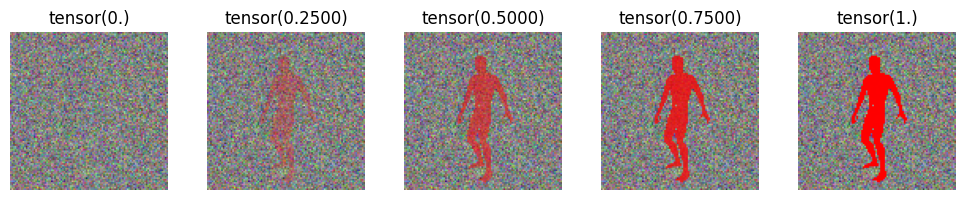

In [7]:
from text3d2video.util import blend_features

n_alphas = 5
alphas = torch.linspace(0, 1, n_alphas)

blended_features = [
    blend_features(original_features, rendered_features, alpha, channel_dim=0)
    for alpha in alphas
]

ims = [TF.to_pil_image(fmap) for fmap in blended_features]
display_ims(ims, titles=alphas)

shape: torch.Size([1, 1, 3, 100, 100]) channel_dim: 2 alpha: 0.5


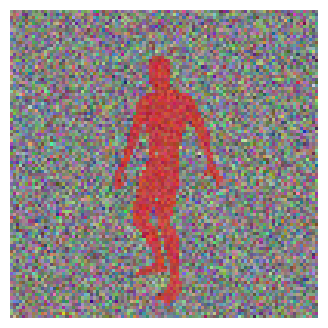

<Figure size 640x480 with 0 Axes>

In [8]:
original_batched = original_features.unsqueeze(0).unsqueeze(0)
rendered_batched = rendered_features.unsqueeze(0).unsqueeze(0)

channel_dim = 2
alpha = 0.5

print("shape:", original_batched.shape, "channel_dim:", channel_dim, "alpha:", alpha)

blended_batched = blend_features(
    original_batched, rendered_batched, 0.5, channel_dim=channel_dim
)

blended = blended_batched[0, 0]

display_ims([TF.to_pil_image(blended)], scale=4)